<a href="https://colab.research.google.com/github/edward-thomson/learn_about_CVR/blob/main/Learn_about_CVR_binder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to CVR Signal Processing**

---



---



# Setting Up


1.   Click on **Runtime** at the top of the Page
2.   Select **Run all**
3.   Wait for a couple of minutes.

If it is taking longer than 3 minutes, check the bottom of the page for an 'Everything has run' message.

Make sure to be logged in to a google account, otherwise some buttons will not be functional. If you are not logged in this may stop you from running the page.






In [ ]:


%%capture --no-stderr
#@title installing packages
!pip install nilearn
!pip install nibabel
!pip install ipympl mpl_interactions
!pip install plotly
!pip install dash
import copy
import json
import os
import warnings
from base64 import b64encode
from io import BytesIO

import matplotlib
import numpy as np
from matplotlib.image import imsave
from nibabel.affines import apply_affine
from IPython.display import display,clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting,image,masking
from nilearn.datasets import load_mni152_template,load_mni152_gm_template,load_mni152_wm_template
import numpy as np
from IPython.display import HTML
from nilearn.plotting.html_document import HTMLDocument
from nilearn.plotting import view_img

import warnings

warnings.filterwarnings('ignore')


def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  init_notebook_mode(connected=False)



# Cerebrovascular Reactivity (CVR)



*   This is the ability of blood vessels to dilate in the brain when a stimulus is applied.
* The stimulus will cause theamount of Carbon Dioxide in your blood to change.
* We measure this change by the peaks in the Carbon Dioxide you breath out. It is called the **Paradigm** or End-tidal CO$_2$ (EtCO$_2$)

*   This can be used an as indicator of the health in the brain.
*   Different tissues in the brain exhibit different CVR responses.


---
**Click the cross hair on the interactive brain, and explore its anatomy.\
Use the buttons in the top corner to highlight the different tissue types.\
Only change Size if the brain is far too small or too big for the screen. It will take a little while to alter the scale.**

Dropdown(description='Size:', options=(600, 800, 1000, 1200, 1400), value=600)

Button(description='Show Grey matter', style=ButtonStyle())

Button(description='Show White matter', style=ButtonStyle())


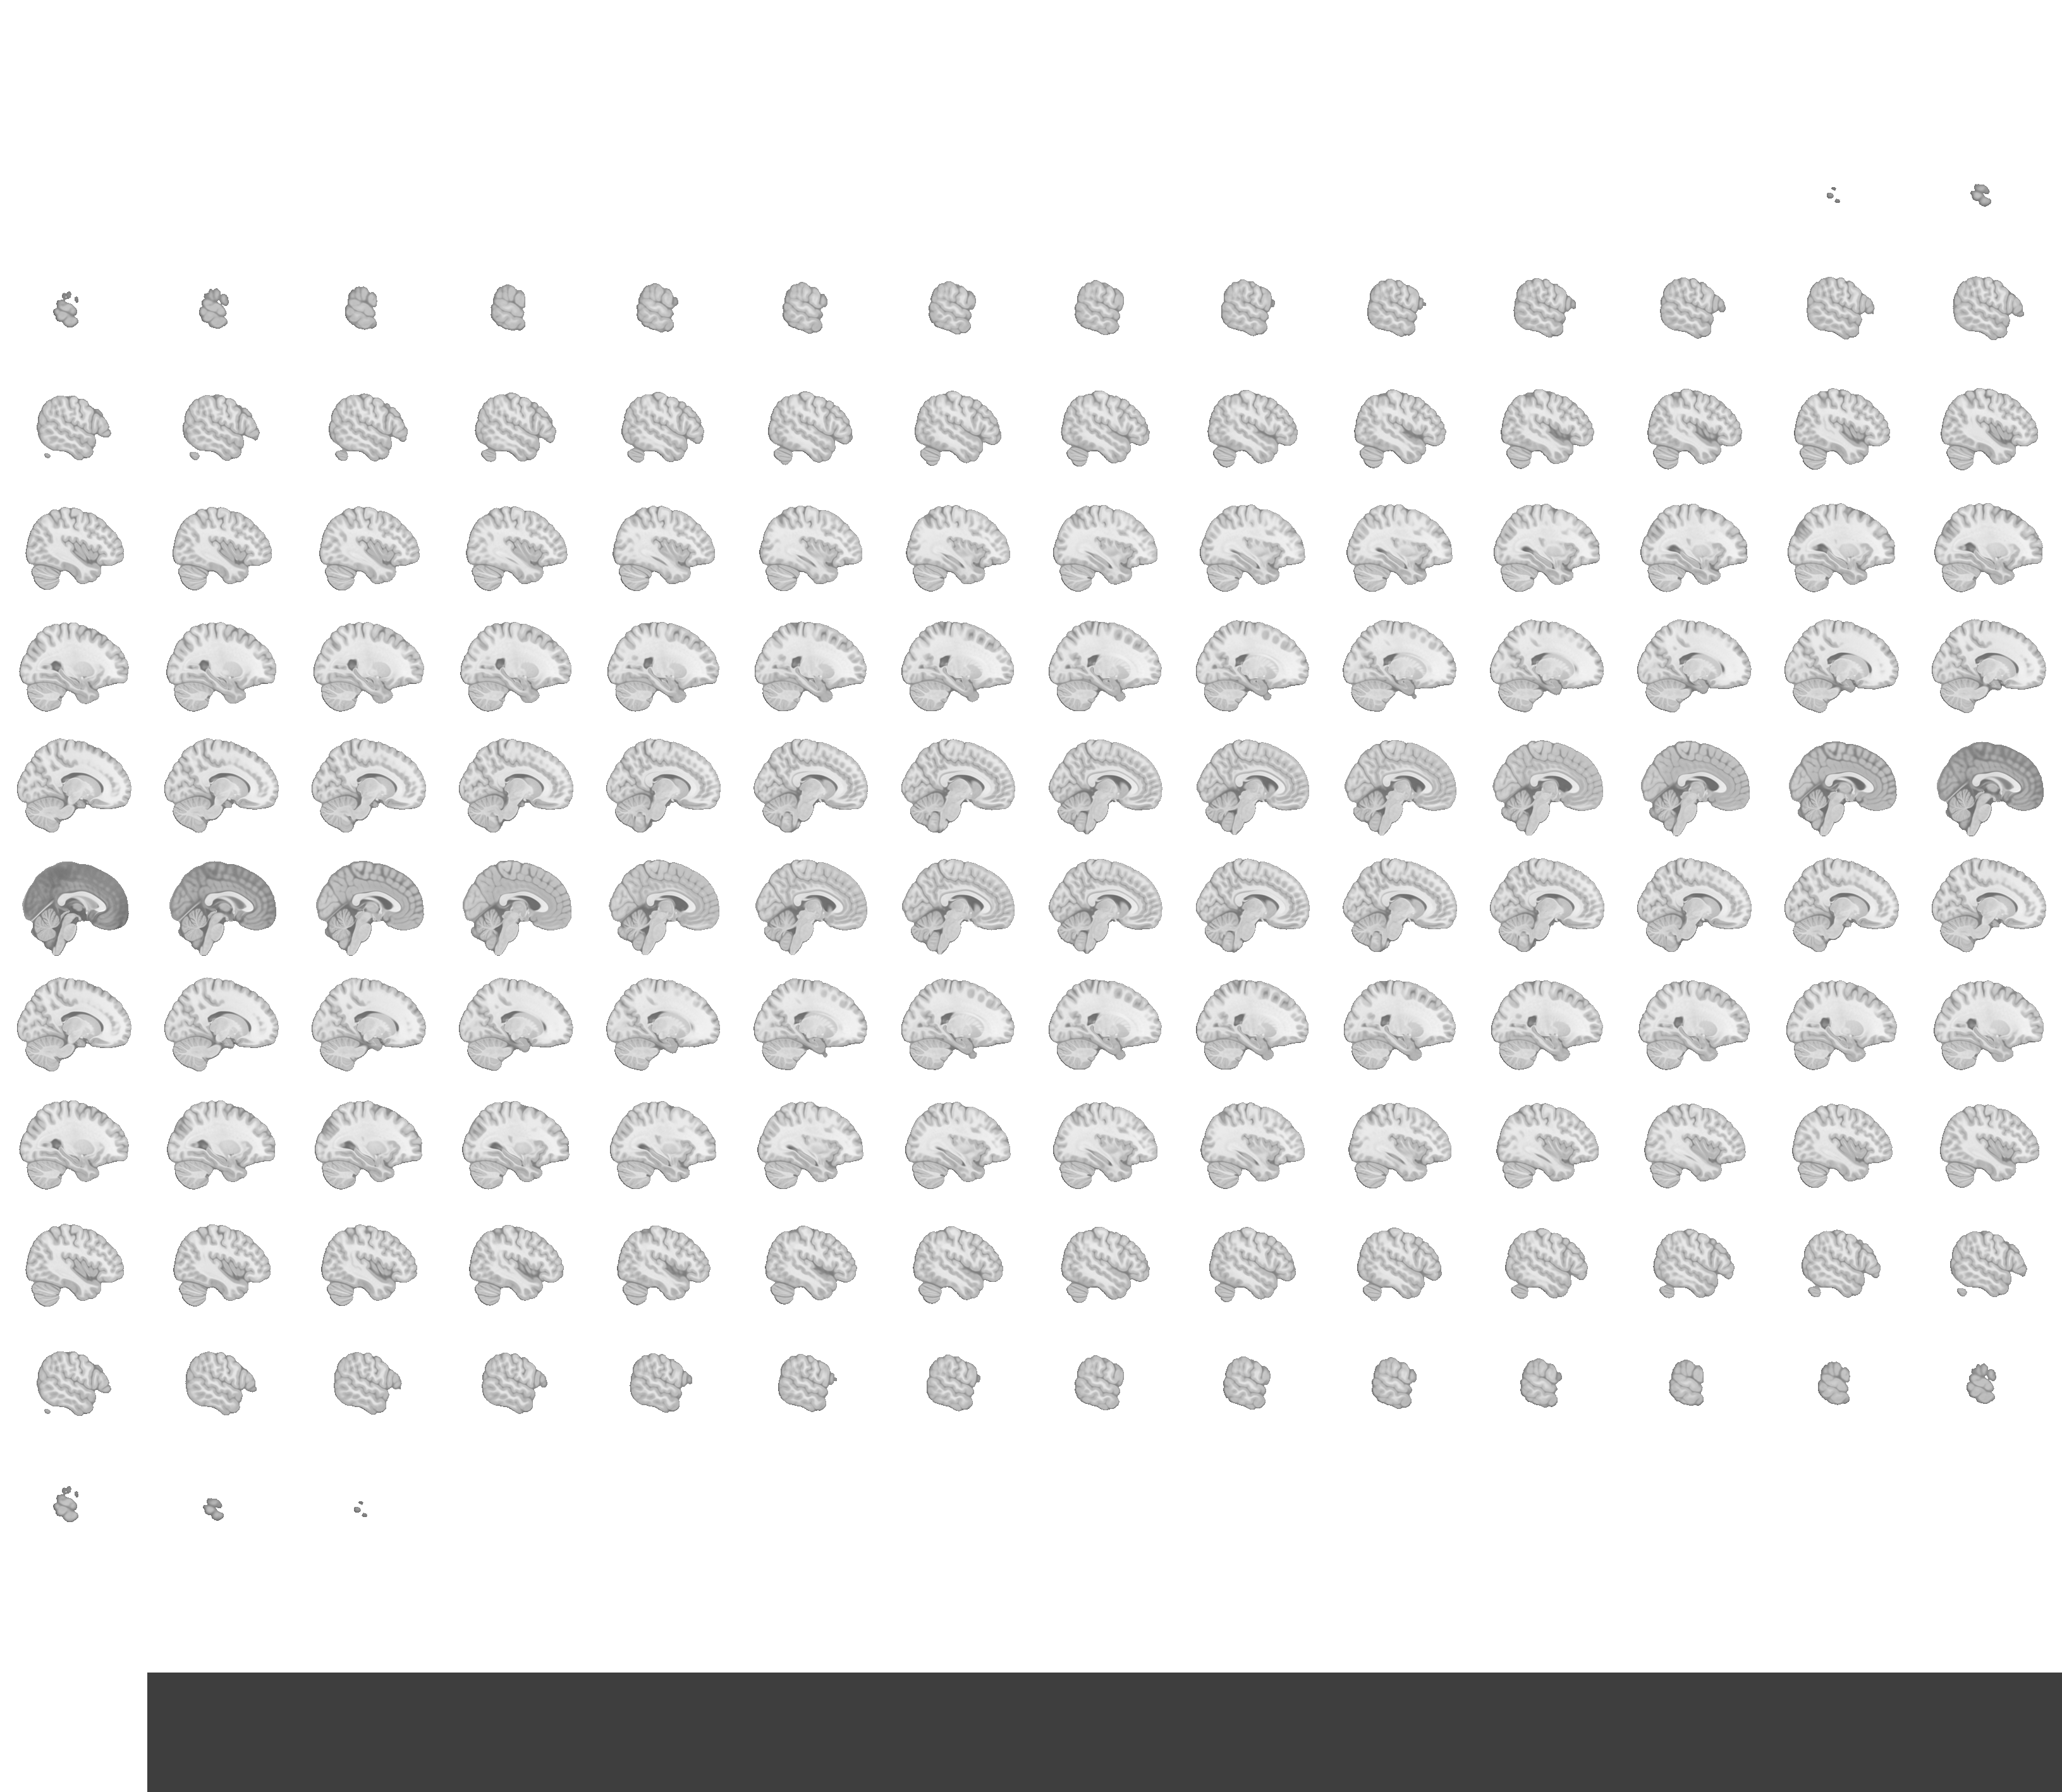
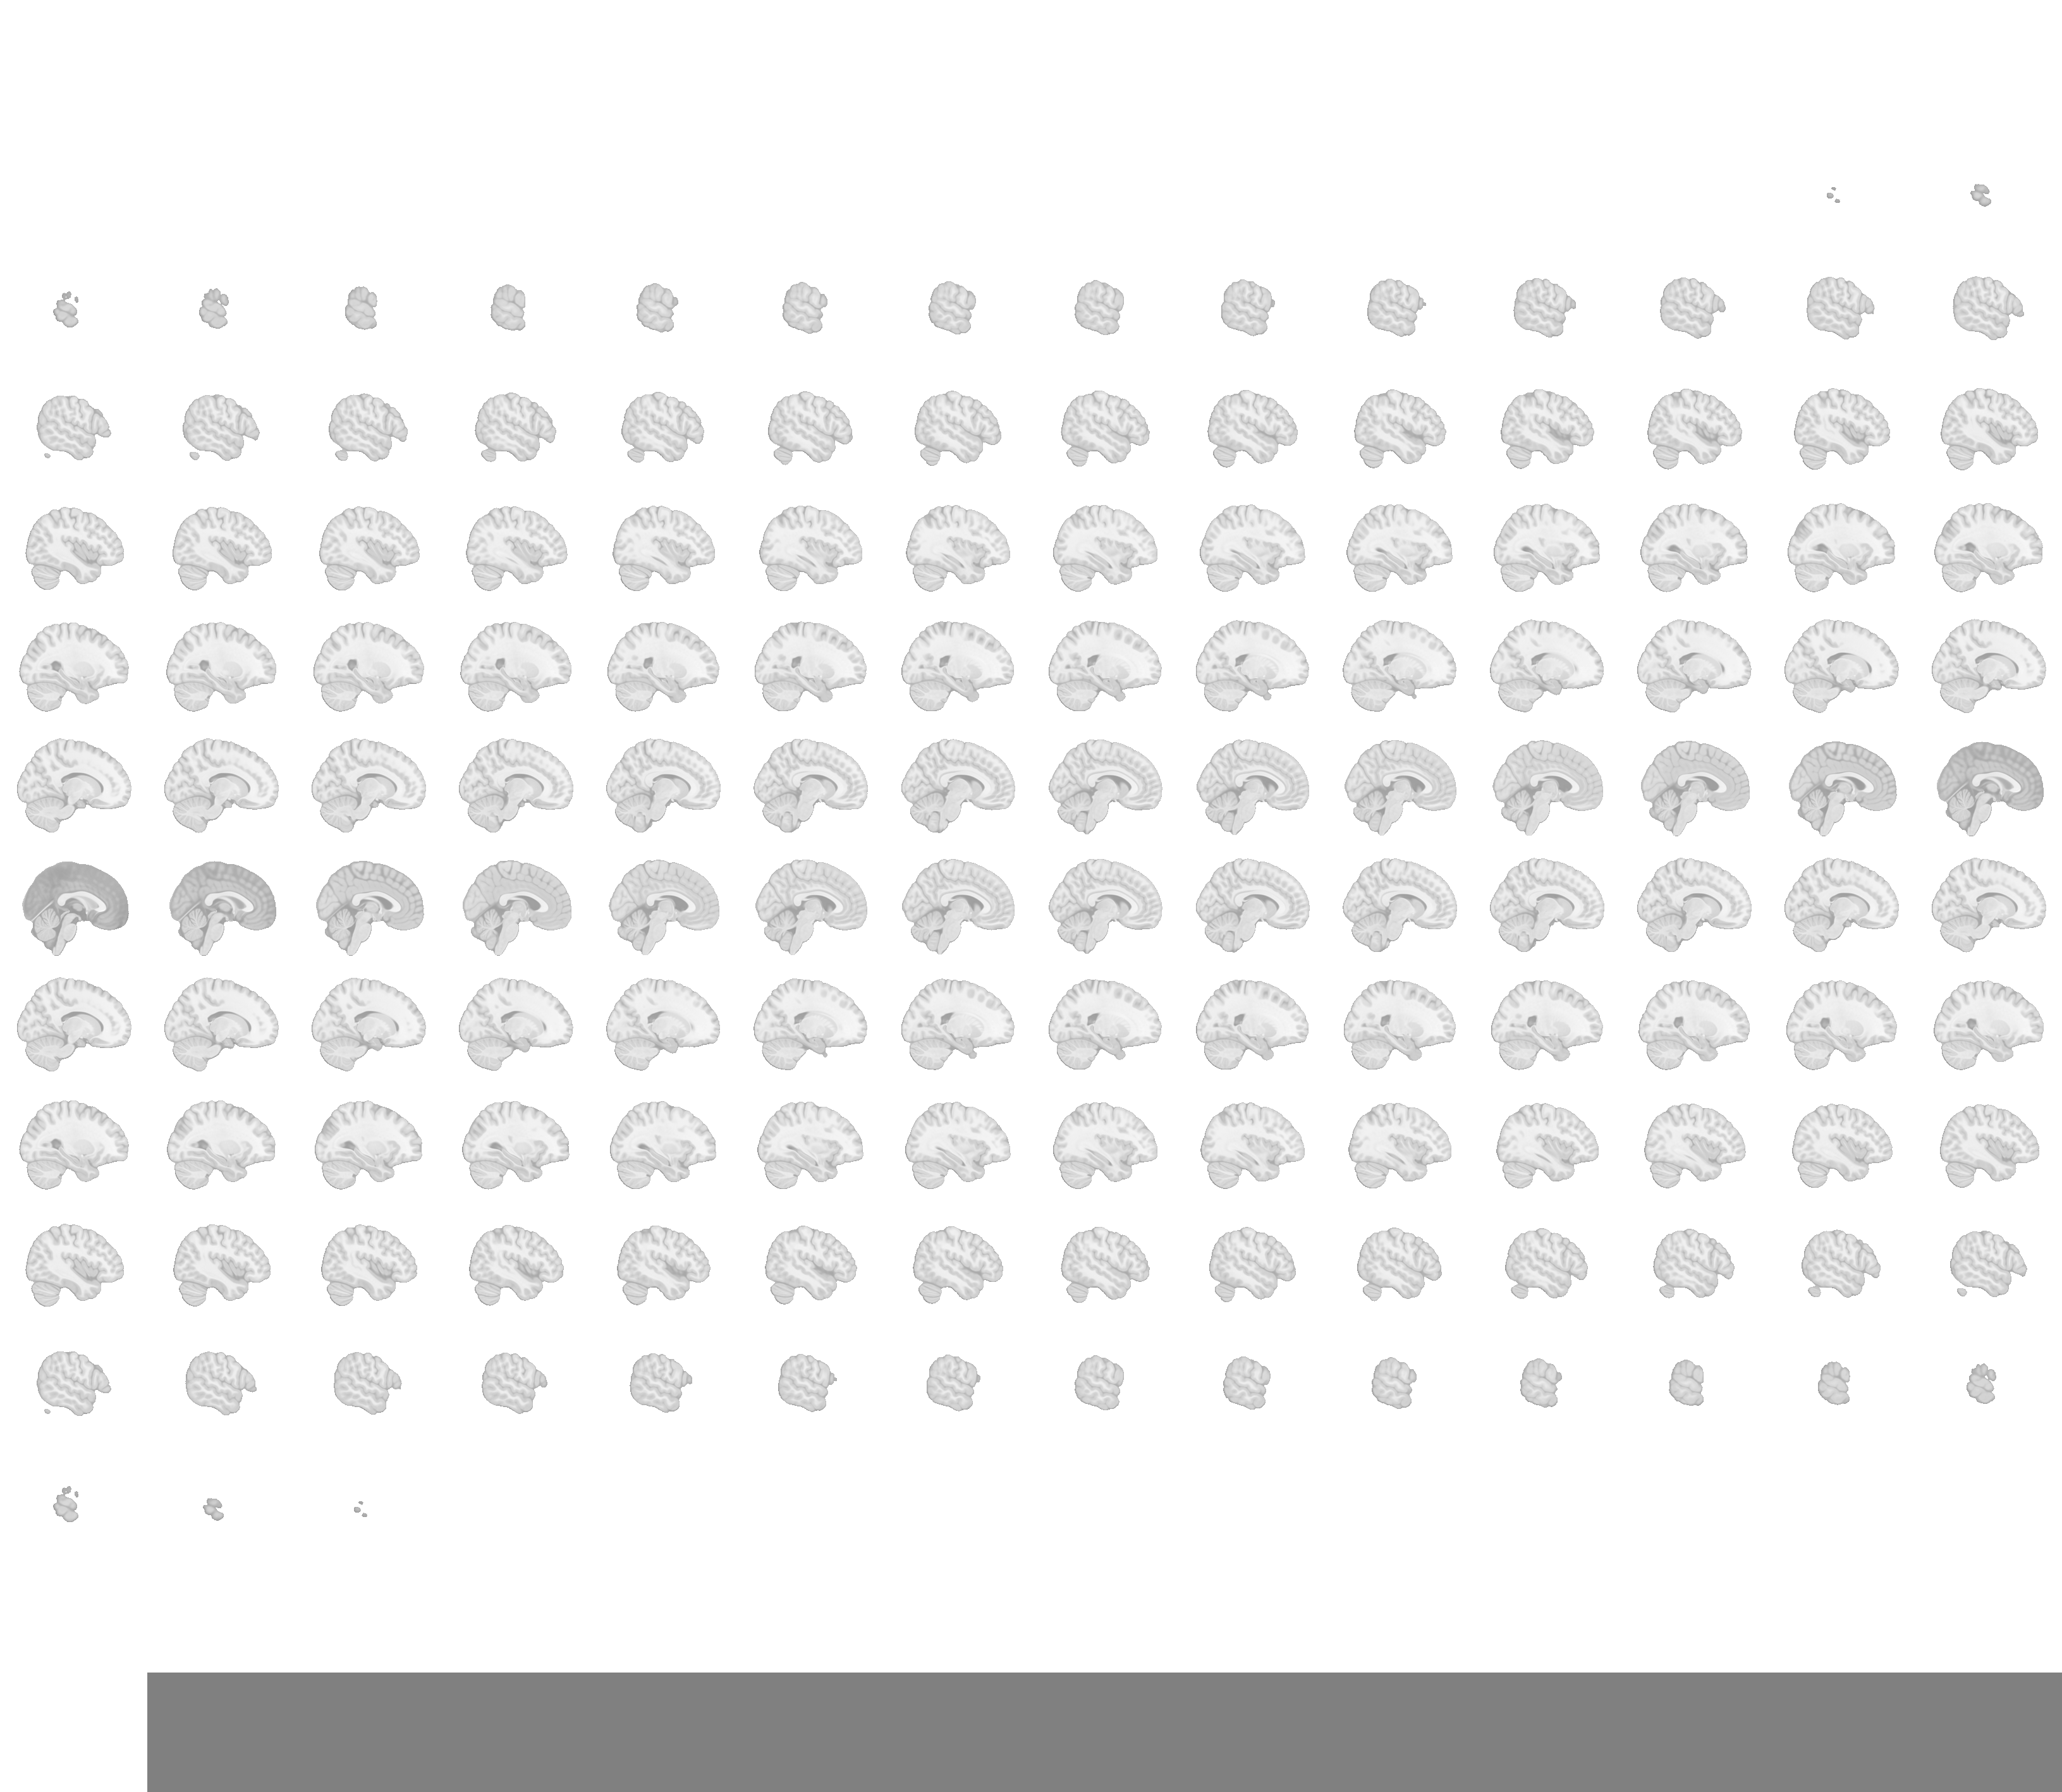

In [ ]:
#@title Interactive Brain
import ipywidgets as widgets
from IPython.display import display
from IPython.display import display as ipydisplay
from IPython.display import Javascript


mni_image = load_mni152_template(resolution = 1)


mask_gm = masking.compute_brain_mask(mni_image, threshold=0.5, connected=True, opening=2, memory=None, verbose=0, mask_type='gm')

gm_mask_bin = nib.Nifti1Image(mask_gm.get_fdata()*0.5,mni_image.affine,mni_image.header)

mask_wm = masking.compute_brain_mask(mni_image, threshold=0.5, connected=True, opening=2, memory=None, verbose=0, mask_type='wm')

wm_mask_bin = nib.Nifti1Image(mask_wm.get_fdata()*-1,mni_image.affine,mni_image.header)


html_mni =  view_img(mni_image,bg_img = mni_image , cmap = 'gist_gray', opacity = 1,colorbar = False,black_bg = False)
html_gm = view_img(gm_mask_bin,bg_img = mni_image , cmap = 'gist_rainbow', opacity = 0.5,colorbar = False,vmax=1,black_bg = False,dim=0)
html_wm = view_img(wm_mask_bin,bg_img = mni_image , cmap = 'gist_rainbow', opacity = 0.5,colorbar = False,vmax=1,threshold=0.5,black_bg = False,dim=0.5)


multi_mask = mask_gm.get_fdata()*0.5 - mask_wm.get_fdata()
multi_mask = nib.Nifti1Image(multi_mask,mni_image.affine,mni_image.header)
html_gm_wm = view_img(multi_mask,bg_img = mni_image , cmap = 'gist_rainbow', opacity = 0.5,colorbar = False,vmax=1,vmin = 0,black_bg = False,dim=0)


def wm_clicked(args):
    clear_output(wait = True)

    
    display(mni_button)
    display(gm_wm_button)
    display(html_wm)

def gm_clicked(args):
    clear_output(wait = True)
    
    display(mni_button)
    display(wm_gm_button)
    display(html_gm)


def mni_clicked(args):
    clear_output(wait = True)
    
    display(gm_button)
    display(wm_button)
    display(html_mni)

def gm_wm_clicked(args):
    clear_output(wait = True)
    
    display(mni_button)
    display(html_gm_wm)



gm_wm_button = widgets.Button(description = 'Show Grey matter')
gm_wm_button.on_click(gm_wm_clicked)

wm_gm_button = widgets.Button(description = 'Show White matter')
wm_gm_button.on_click(gm_wm_clicked)



wm_button = widgets.Button(description = 'Show White matter')
wm_button.on_click(wm_clicked)

gm_button = widgets.Button(description = 'Show Grey matter')
gm_button.on_click(gm_clicked)

mni_button = widgets.Button(description = 'clear overlay')
mni_button.on_click(mni_clicked)

display(gm_button)
display(wm_button)
display(html_mni)

mni_button = widgets.Button(description = 'clear overlay')
mni_button.on_click(mni_clicked)


# BOLD imaging

* BOLD imaging is a type of MRI scan
* Creates a picture based on the oxygen in the blood in your brain
* Made of 3D pixels, called voxels
* It is used when measuring CVR
---

Here is an example of a BOLD image

<img src = 'https://drive.google.com/uc?id=1cXZ-JLdTw9Owmeql3aHHXaN-PKOYAXsw' width = '600'>


* By taking lots of BOLD scans we get a signal for each voxel over time



# How do the paradigm and BOLD signal relate?



*   The stimulus causes Carbon dioxide in the blood to increase.

* More blood is needed in tissue to keep it healthy.
* This causes a change in our BOLD signal.
*  Depending on the CVR of a tissue, the BOLD signal will change in different ways.
* The CVR magnitude is how big the change in BOLD signal is.
* The CVR delay is how long the change in BOLD signal takes.
* The signals are also noisy, making it hard to relate the two signals

---
**Create your own BOLD signal, and explore what the BOLD signal looks like at a different CVR magnitude and delay**.



In [ ]:
#@title Create Your BOLD Signal

import dash
from dash import dcc, html, Input, Output
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
BOLD = None
app = dash.Dash(__name__)

app.layout = html.Div([
    html.Div([
        html.Label('CVR magnitude:'),
        dcc.Slider(
            id='magnitude-slider',
            min=0,
            max=2,
            step=0.01,
            value=1,
            marks={i: str(i) for i in range(11)},
            updatemode='drag'
        ),
        html.Label('CVR delay:'),
        dcc.Slider(
            id='delay-slider',
            min=0,
            max=100,
            step=1,
            value=0,
            marks={i: str(i) for i in range(-10, 202, 20)},
            updatemode='drag'
        ),
        html.Label('Noise'),
        dcc.Slider(
            id='noise-slider',
            min=0,
            max=10,
            step=0.5,
            value=0,
            marks={i: str(i) for i in range(11)},
            updatemode='drag'
        ),
    ], style={'width': '50%', 'margin': 'auto', 'font-family': 'Arial'}),
    dcc.Graph(id='bold-graph'),
    html.Div(id='output-div')
])


def create_BOLD_signal(CVR_magnitude, CVR_delay, noise_std):
    EtCO2 = np.concatenate([40. * np.ones(120),
                            50. * np.ones(180),
                            40. * np.ones(120),
                            50. * np.ones(180),
                            40. * np.ones(121)])

    CVR_magnitude /= 100
    BOLD = EtCO2 * CVR_magnitude
    BOLD_baseline = 300

    baseline = np.mean(BOLD[1:100])

    if CVR_delay < 0:
        BOLD = np.concatenate([BOLD[abs(int(np.ceil(CVR_delay))):], np.tile(baseline, abs(int(np.ceil(CVR_delay))))])
    elif CVR_delay > 0:
        BOLD = np.concatenate([np.tile(baseline, int(np.ceil(CVR_delay))), BOLD[:len(BOLD) - int(np.ceil(CVR_delay))]])

    BOLD = BOLD_baseline * BOLD + BOLD_baseline * (1 - CVR_magnitude * EtCO2[0])

    if noise_std != 0:
        noise = np.random.normal(0, 1, size=len(BOLD))
        noise = ((noise - np.mean(noise)) / np.std(noise)) * noise_std
        noise = noise - np.mean(noise)
        BOLD += noise

    return BOLD, EtCO2


@app.callback(
    Output('bold-graph', 'figure'),
    [Input('magnitude-slider', 'value'),
     Input('delay-slider', 'value'),
     Input('noise-slider', 'value')]
)
def update_graph(CVR_magnitude, CVR_delay, noise_std):
    global BOLD
    BOLD, EtCO2 = create_BOLD_signal(CVR_magnitude, CVR_delay, noise_std)

    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=np.arange(len(BOLD)), y=BOLD, mode='lines', name='BOLD signal'), secondary_y=False)
    fig.add_trace(go.Scatter(x=np.arange(len(EtCO2)), y=EtCO2, mode='lines', name='Paradigm'), secondary_y=True)
    fig.update_layout(title="",  # Removed the title
                      xaxis_title='Time', template='plotly_white',
                      yaxis=dict(title='BOLD signal (a.u)'),
                      yaxis2=dict(title='EtCO2 (a.u)', autorange=False,
                                  range=[np.min(EtCO2), np.max(EtCO2)*(CVR_magnitude/10 + 1)]))


    # Return the figure and the mean BOLD signal
    return fig

if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

* At high noise, and low CVR magnitude, its hard to see any change due to the paradigm
* It also becomes quite hard to tell how delayed our signal was.
* This shows some of the challenges you face when measuring CVR

# Measuring the CVR of different tissues

 * Our white matter and grey matter have different CVRs. White matter will have a long delay around 25s, but a small magnitudes, around 0.1%/mmHg. Grey matter will have short delays, around 10s, but large magnitudes, around 0.25%/mmHg.
 * Here we have a BOLD signal from one of the tissues.
 ---
 * We measure our CVR in a reverse of making the BOLD signal display above.
 * We want to find the CVR delay first. We shift our paradigm in time along the BOLD signal and work out where they best match. The size of the shift is our CVR delay
 * **Use the slider underneath the BOLD signal, find the delay with the highest correlation coefficient. This is the best delay, as this is the paradigm. Enter the delay into the box**
 ---
 * We then need our CVR magnitude to fully describe the relationship between the BOLD signal and the paradigm. To find this, we will plot our BOLD signal, against our shifted paradimg. We then find the line that best matches these points. This is the line of best fit.
 * The gradient of this line describes how our BOLD signal changes depending on a change in the paradigm. This is our CVR magnitude.
 * **Once you enter your delay, the plot will appear. Use the slider underneath to adjust the gradient of the line so there are an even number of points each side. Then enter the asscociated CVR magnitude underneath into the box**
 ---
 Now you have chosen what your delay and magnitude are, try to guess the tissue. Don't worry if you get it wrong, just press rerun to measure a new signal.


In [ ]:
#@title Measuring CVR values

import plotly.graph_objects as go
import numpy as np
from ipywidgets import FloatText, VBox
from IPython.display import Javascript,Markdown
import random
from scipy.stats import linregress

display(Markdown('# Lets measure the CVR delay'))
display(Markdown('Move the slider to try to get the two signals to match. Look at the top left corner to for a clue.'))
display(Markdown('The signal with the highest correlation coefficent is the best delay'))


Best_paradigm = None
def random_BOLD_signal():
    EtCO2 = np.concatenate([40. * np.ones(120),
                            50. * np.ones(180),
                            40. * np.ones(120),
                            50. * np.ones(180),
                            40. * np.ones(121)])

    NAWM_vars = [0.1,0.1,30,20]
    gm_vars = [0.25,0.2,10,7]
    global random_int
    random_int = bool(np.random.randint(2))
    if random_int == True:
      CVR_magnitude1 = np.abs(np.random.normal(NAWM_vars[0],NAWM_vars[1],1))
      CVR_delay = int(np.ceil(np.abs(np.random.normal(NAWM_vars[2],NAWM_vars[3],1))))
    else:
      CVR_magnitude1 = np.abs(np.random.normal(gm_vars[0],gm_vars[1],1))
      CVR_delay = int(np.ceil(np.abs(np.random.normal(gm_vars[2],gm_vars[3],1))))

    noise_std = np.abs(np.random.normal(0.4,1.5,1))


    CVR_magnitude = CVR_magnitude1/100
    BOLD = EtCO2 * CVR_magnitude
    BOLD_baseline = 300

    baseline = np.mean(BOLD[1:100])

    if CVR_delay < 0:
        BOLD = np.concatenate([BOLD[abs(int(np.ceil(CVR_delay))):], np.tile(baseline, abs(int(np.ceil(CVR_delay))))])
    elif CVR_delay > 0:
        BOLD = np.concatenate([np.tile(baseline, int(np.ceil(CVR_delay))), BOLD[:len(BOLD) - int(np.ceil(CVR_delay))]])

    BOLD = BOLD_baseline * BOLD + BOLD_baseline * (1 - CVR_magnitude * EtCO2[0])

    if noise_std != 0:
        noise = np.random.normal(0, 1, size=len(BOLD))
        noise = ((noise - np.mean(noise)) / np.std(noise)) * noise_std
        noise = noise - np.mean(noise)
        BOLD += noise

    return BOLD, EtCO2,CVR_magnitude1,CVR_delay,noise_std


def shift_paradigm(step):
    EtCO2 = np.concatenate([40. * np.ones(120),
                            50. * np.ones(180),
                            40. * np.ones(120),
                            50. * np.ones(180),
                            40. * np.ones(121)])



    shifted_paradigm = np.concatenate([np.tile(40, int(np.ceil(step))), EtCO2[:len(EtCO2) - int(np.ceil(step))]])

    global Best_paradigm
    Best_paradigm = shifted_paradigm
    return shifted_paradigm


BOLD, EtCO2,CVR_magnitude1,CVR_delay,noise_std = random_BOLD_signal()

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

fig = go.Figure()

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=np.arange(len(BOLD)), y=BOLD, mode='lines', name='BOLD signal'), secondary_y=False)

rs = []

for step in np.arange(0, 91, 1):
    fig.add_trace(
        go.Scatter(visible=False,
                   x=np.arange(0,len(EtCO2),1),
                   y=shift_paradigm(step), mode='lines', name='Paradigm'), secondary_y=True)

    rs.append(np.abs(np.corrcoef(BOLD, shift_paradigm(step)))[0,1])

fig.data[1].visible = True

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [j == 0 or j == i for j in range(len(fig.data))]},
              {"title": f'Delay: {i-1}s Correlation coefficient: {rs[i-1]:.3f}'}],value=i,label=str(i-1)  # layout attribute
    )

    steps.append(step)

sliders = [dict(
    active=10,
    steps=steps[1:],
    ticklen=0,
    tickcolor='rgba(0,0,0,0)'
)]

fig.update_layout(title="",
                  xaxis_title='Time', template='plotly_white',
                  yaxis=dict(title='BOLD signal (a.u)'),
                  yaxis2=dict(title='EtCO2 (a.u)'), sliders=sliders)

fig.show()

best_delay = None
float_input = FloatText(description='Best Delay:', value=0.0)

def handle_input_change(change):
    try:
        global best_delay
        best_delay = float_input.value

        display(Markdown('# Now lets measure the CVR magnitude'))
        display(Markdown('Move the slider to try to get the line to be inbetween the the most points'))
        display(Markdown('This is the line of best fit between the Paradigm and the BOLD signal'))

        Best_paradigm = shift_paradigm(int(best_delay))
        slope, intercept, r, p, se = linregress(Best_paradigm,BOLD)

        fig = go.Figure()

        fig = make_subplots(
            rows=1, cols=1,
            row_heights=[1],
            vertical_spacing=0.8,
        )

        fig.add_trace(go.Scatter(x=Best_paradigm, y=BOLD, mode='markers'))

        rs = []
        x = np.linspace(0, 500, 100)

        def line_of_best_fit(step,intercept):
            return (step) * x + intercept

        step_range = np.arange(slope - 0.2, slope + 0.2, 0.001)
        for step in step_range:
            fig.add_trace(
                go.Scatter(visible=False,
                           x=x,
                           y=line_of_best_fit(step,intercept), mode='lines', name='Paradigm'))

            rs.append(np.abs(np.corrcoef(BOLD, shift_paradigm(step)))[0,1])

        fig.data[1].visible = True

        steps = []
        for i in range(len(fig.data)):
            step = dict(
                method="update",
                args=[{"visible": [j == 0 or j == i for j in range(len(fig.data))]},
                      {"title": f'CVR Magnitude: {step_range[i-1]/3:.6f}s '}],value='',label='  ')

            steps.append(step)

        sliders = [dict(
            active=10,
            steps=steps[1:],
            ticklen=0,
            tickcolor='rgba(0,0,0,0)'
        )]

        fig.update_layout(title="",
                          xaxis_title='Paradigm (mmHg)', template='plotly_white',
                          yaxis=dict(title='BOLD signal (a.u)'),
                          sliders=sliders,height=600, width=900,
                          xaxis_range=(np.min(Best_paradigm)-5, np.max(Best_paradigm)+5),
                          yaxis_range=(np.min(BOLD)-5, np.max(BOLD)+5))

        fig.show()

        # Call the function to display the second input box after showing the graph
        display_second_input_box()



    except ValueError:
        print("Invalid input. Please enter a delay estimate.")

def display_second_input_box():
    global float_input1

    float_input1 = FloatText(description='Best CVR magnitude:', value=0.0)
    float_input1.observe(handle_input_change1, names='value')
    display(float_input1)

def rerun(b):
    clear_output(wait=True)
    display(Markdown('# Lets measure the CVR delay'))
    display(Markdown('Move the slider to try to get the two signals to match. Look at the top left corner to for a clue.'))
    display(Markdown('The signal with the highest correlation coefficent is the best delay'))
    Best_paradigm = None
    def random_BOLD_signal():
        EtCO2 = np.concatenate([40. * np.ones(120),
                                50. * np.ones(180),
                                40. * np.ones(120),
                                50. * np.ones(180),
                                40. * np.ones(121)])

        NAWM_vars = [0.1,0.1,30,20]
        gm_vars = [0.25,0.2,10,7]
        global random_int
        random_int = bool(np.random.randint(2))
        if random_int == True:
          CVR_magnitude1 = np.abs(np.random.normal(NAWM_vars[0],NAWM_vars[1],1))
          CVR_delay = int(np.ceil(np.abs(np.random.normal(NAWM_vars[2],NAWM_vars[3],1))))
        else:
          CVR_magnitude1 = np.abs(np.random.normal(gm_vars[0],gm_vars[1],1))
          CVR_delay = int(np.ceil(np.abs(np.random.normal(gm_vars[2],gm_vars[3],1))))

        noise_std = np.abs(np.random.normal(0.4,1.5,1))


        CVR_magnitude = CVR_magnitude1/100
        BOLD = EtCO2 * CVR_magnitude
        BOLD_baseline = 300

        baseline = np.mean(BOLD[1:100])

        if CVR_delay < 0:
            BOLD = np.concatenate([BOLD[abs(int(np.ceil(CVR_delay))):], np.tile(baseline, abs(int(np.ceil(CVR_delay))))])
        elif CVR_delay > 0:
            BOLD = np.concatenate([np.tile(baseline, int(np.ceil(CVR_delay))), BOLD[:len(BOLD) - int(np.ceil(CVR_delay))]])

        BOLD = BOLD_baseline * BOLD + BOLD_baseline * (1 - CVR_magnitude * EtCO2[0])

        if noise_std != 0:
            noise = np.random.normal(0, 1, size=len(BOLD))
            noise = ((noise - np.mean(noise)) / np.std(noise)) * noise_std
            noise = noise - np.mean(noise)
            BOLD += noise

        return BOLD, EtCO2,CVR_magnitude1,CVR_delay,noise_std


    def shift_paradigm(step):
        EtCO2 = np.concatenate([40. * np.ones(120),
                                50. * np.ones(180),
                                40. * np.ones(120),
                                50. * np.ones(180),
                                40. * np.ones(121)])



        shifted_paradigm = np.concatenate([np.tile(40, int(np.ceil(step))), EtCO2[:len(EtCO2) - int(np.ceil(step))]])

        global Best_paradigm
        Best_paradigm = shifted_paradigm
        return shifted_paradigm


    BOLD, EtCO2,CVR_magnitude1,CVR_delay,noise_std = random_BOLD_signal()

    display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

    fig = go.Figure()

    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=np.arange(len(BOLD)), y=BOLD, mode='lines', name='BOLD signal'), secondary_y=False)

    rs = []

    for step in np.arange(0, 91, 1):
        fig.add_trace(
            go.Scatter(visible=False,
                      x=np.arange(0,len(EtCO2),1),
                      y=shift_paradigm(step), mode='lines', name='Paradigm'), secondary_y=True)

        rs.append(np.abs(np.corrcoef(BOLD, shift_paradigm(step)))[0,1])

    fig.data[1].visible = True

    # Create and add slider
    steps = []
    for i in range(len(fig.data)):
        step = dict(
            method="update",
            args=[{"visible": [j == 0 or j == i for j in range(len(fig.data))]},
                  {"title": f'Delay: {i-1}s Correlation coefficient: {rs[i-1]:.3f}'}],value=i,label=str(i-1)  # layout attribute
        )

        steps.append(step)

    sliders = [dict(
        active=10,
        steps=steps[1:],
        ticklen=0,
        tickcolor='rgba(0,0,0,0)'
    )]

    fig.update_layout(title="",
                      xaxis_title='Time', template='plotly_white',
                      yaxis=dict(title='BOLD signal (a.u)'),
                      yaxis2=dict(title='EtCO2 (a.u)'), sliders=sliders)

    fig.show()

    best_delay = None
    float_input = FloatText(description='Best Delay:', value=0.0)

    def handle_input_change(change):
        try:
            global best_delay
            best_delay = float_input.value
            display(Markdown(f'You have chosen {best_delay}s as the delay'))
            display(Markdown('# Now lets measure the CVR magnitude'))
            display(Markdown('Move the slider to try to get the line to be inbetween the the most points'))
            display(Markdown('This is the line of best fit between the Paradigm and the BOLD signal'))
            Best_paradigm = shift_paradigm(int(best_delay))
            slope, intercept, r, p, se = linregress(Best_paradigm,BOLD)

            fig = go.Figure()

            fig = make_subplots(
                rows=1, cols=1,
                row_heights=[1],
                vertical_spacing=0.8,
            )

            fig.add_trace(go.Scatter(x=Best_paradigm, y=BOLD, mode='markers'))

            rs = []
            x = np.linspace(0, 500, 100)

            def line_of_best_fit(step,intercept):
                return (step) * x + intercept

            step_range = np.arange(slope - 0.3, slope + 0.3, 0.001)
            for step in step_range:
                fig.add_trace(
                    go.Scatter(visible=False,
                              x=x,
                              y=line_of_best_fit(step,intercept), mode='lines', name='Paradigm'))

                rs.append(np.abs(np.corrcoef(BOLD, shift_paradigm(step)))[0,1])

            fig.data[1].visible = True

            steps = []
            for i in range(len(fig.data)):
                step = dict(
                    method="update",
                    args=[{"visible": [j == 0 or j == i for j in range(len(fig.data))]},
                          {"title": f'CVR Magnitude: {step_range[i-1]/3:.6f}s '}],value='',label='  ')

                steps.append(step)

            sliders = [dict(
                active=10,
                steps=steps[1:],
                ticklen=0,
                tickcolor='rgba(0,0,0,0)'
            )]

            fig.update_layout(title="",
                              xaxis_title='Paradigm (mmHg)', template='plotly_white',
                              yaxis=dict(title='BOLD signal (a.u)'),
                              sliders=sliders,height=600, width=900,
                              xaxis_range=(np.min(Best_paradigm)-5, np.max(Best_paradigm)+5),
                              yaxis_range=(np.min(BOLD)-5, np.max(BOLD)+5))

            fig.show()

            # Call the function to display the second input box after showing the graph
            display_second_input_box()



        except ValueError:
            print("Invalid input. Please enter a delay estimate.")

    def display_second_input_box():
        global float_input1

        float_input1 = FloatText(description='', value=0.0)
        float_input1.observe(handle_input_change1, names='value')
        display(float_input1)

    def handle_input_change1(change):
        try:
            best_mag = float_input1.value

            display(Markdown('# What tissue do you think it is'))
            def white_matter_clicked(b):
                global best_delay
                if random_int == True:
                    display(Markdown('**You got it right!  :) **, the signal was produced by white matter'))
                    display(Markdown(f'Your estimated CVR delay was {best_delay}s, the actual CVR delay was {CVR_delay}s'))
                    display(Markdown(f'Your estimated CVR magnitude was {best_mag:.3}%/mmHg, the actual CVR magnitude was {CVR_magnitude1[0]:.3}%/mmHg'))
                else:
                    display(Markdown('**You got it Wrong!  :(**, the signal was produced by Grey matter'))
                    display(Markdown(f'Your estimated CVR delay was {best_delay}s, the actual CVR delay was {CVR_delay}s'))
                    display(Markdown(f'Your estimated CVR magnitude was {best_mag:.3}%/mmHg, the actual CVR magnitude was {CVR_magnitude1[0]:.3}%/mmHg'))

                rerun_button = widgets.Button(description="Run again")
                rerun_button.on_click(rerun)
                widgets.VBox([rerun_button])
                display(rerun_button)


            def grey_matter_clicked(b):
                global best_delay
                if random_int == True:
                    display(Markdown('**You got it Wrong!  :) **, the signal was produced by white matter'))
                    display(Markdown(f'Your estimated CVR delay was {best_delay}s, the actual CVR delay was {CVR_delay}s'))
                    display(Markdown(f'Your estimated CVR magnitude was {best_mag:.3}%/mmHg, the actual CVR magnitude was {CVR_magnitude1[0]:.3}%/mmHg'))
                else:
                    display(Markdown('**You got it Right!  :(**, the signal was produced by Grey matter'))
                    display(Markdown(f'Your estimated CVR delay was {best_delay}s, the actual CVR delay was {CVR_delay}s'))
                    display(Markdown(f'Your estimated CVR magnitude was {best_mag:.3}%/mmHg, the actual CVR magnitude was {CVR_magnitude1[0]:.3}%/mmHg'))

                rerun_button = widgets.Button(description="Run again")
                rerun_button.on_click(rerun)
                widgets.VBox([rerun_button])
                display(rerun_button)


            white_matter_button = widgets.Button(description="White Matter")
            grey_matter_button = widgets.Button(description="Grey Matter")
            white_matter_button.on_click(white_matter_clicked)
            grey_matter_button.on_click(grey_matter_clicked)
            widgets.VBox([white_matter_button, grey_matter_button])
            display(white_matter_button,grey_matter_button)

        except ValueError:
            print("Invalid input. Please enter a magnitude estimate.")

    float_input.observe(handle_input_change, names='value')

    display(Markdown('Type the delay you think is best, and then press the Enter Key'))
    display(float_input)


def handle_input_change1(change):
    try:
        best_mag = float_input1.value

        display(Markdown('# What tissue do you think it is'))
        def white_matter_clicked(b):
            global best_delay
            if random_int == True:
                display(Markdown('**You got it right!  :) **, the signal was produced by white matter'))
                display(Markdown(f'Your estimated CVR delay was {best_delay}s, the actual CVR delay was {CVR_delay}s'))
                display(Markdown(f'Your estimated CVR magnitude was {best_mag}%/mmHg, the actual CVR magnitude was {CVR_magnitude1[0]:.3}%/mmHg'))
            else:
                display(Markdown('**You got it Wrong!  :(**, the signal was produced by Grey matter'))
                display(Markdown(f'Your estimated CVR delay was {best_delay}s, the actual CVR delay was {CVR_delay}s'))
                display(Markdown(f'Your estimated CVR magnitude was {best_mag}%/mmHg, the actual CVR magnitude was {CVR_magnitude1[0]:.3}%/mmHg'))

            rerun_button = widgets.Button(description="Run again")
            rerun_button.on_click(rerun)
            widgets.VBox([rerun_button])
            display(rerun_button)


        def grey_matter_clicked(b):
            if random_int == True:
                display(Markdown('*You got it Wrong!  :(*, the signal was produced by white matter'))
                display(Markdown(f'Your estimated CVR delay was {best_delay}s, the actual CVR delay was {CVR_delay}s'))
                display(Markdown(f'Your estimated CVR magnitude was {best_mag}%/mmHg, the actual CVR magnitude was {CVR_magnitude1[0]:.3}%/mmHg'))
            else:
                display(Markdown('*You got it Right!  :)*, the signal was produced by Grey matter'))
                display(Markdown(f'Your estimated CVR delay was {best_delay}s, the actual CVR delay was {CVR_delay}s'))
                display(Markdown(f'Your estimated CVR magnitude was {best_mag:.3}%/mmHg, the actual CVR magnitude was {CVR_magnitude1[0]:.3}%/mmHg'))

            rerun_button = widgets.Button(description="Run again")
            rerun_button.on_click(rerun)
            widgets.VBox([rerun_button])
            display(rerun_button)


        white_matter_button = widgets.Button(description="White Matter")
        grey_matter_button = widgets.Button(description="Grey Matter")
        white_matter_button.on_click(white_matter_clicked)
        grey_matter_button.on_click(grey_matter_clicked)
        widgets.VBox([white_matter_button, grey_matter_button])
        display(white_matter_button,grey_matter_button)



    except ValueError:
        print("Invalid input. Please enter a magnitude estimate.")

float_input.observe(handle_input_change, names='value')

display(Markdown('Type the delay you think is best, and then press the Enter Key'))
display(float_input)


# Lets measure the CVR delay

Move the slider to try to get the two signals to match. Look at the top left corner to for a clue.

The signal with the highest correlation coefficent is the best delay

<IPython.core.display.Javascript object>

Type the delay you think is best, and then press the Enter Key

FloatText(value=0.0, description='Best Delay:')

# You've done it
* you have now learned how a BOLD signal and the paradigm that causes a cerebrovascular reaction relate to one another, and the standard method of measuring it.
* By doing this for every voxel in a BOLD scan, a map of the CVR values can be created. Healthy and unhealthy tissues should appear differently in this map.

---
**There were some challenges along the way**

* As you would have found by now, sometimes BOLD signals are hard to measure. They can have lots of noise making it hard to match up our signals. On top of that, if you get the delay wrong, when you try to find the magnitude, you also get it wrong.

* As well as that, sometimes white and grey matter give similar CVR values, making it pretty hard to work out.
* These are just some of the challenges facing CVR measurement. For unhealthy tissue to be identified with CVR, these must be overcome.

# Thank you for Learning the basics of CVR signal processing

---



In [ ]:
#@title ______________________
print('Everything is Run')

Everything is Run
